# `Lasso & Ridge Implemented in R-Studio`

**And a surpise: Elastic Net**

# <font color=red>Mr Fugu Data Science</font>

# (◕‿◕✿)

# `Purpose & Outcome:`
+ Use an example to describe how R-studio is working
+ go over some of the theory while implementing
+ explain some of the hangups with these approaches

[dataset background](https://cran.r-project.org/web/packages/AmesHousing/AmesHousing.pdf) | [example motivation adpated](https://uc-r.github.io/regularized_regression) | [alternate motivation](https://rpubs.com/RobbyS/622233)

`Consider also: Boston Housing, diamond dataset for practice`

# `Help Support This Channel: `

**`buy me a coffee: @mrfugudatasci`**

`-----------------------`

`There is two problems I have with how we are taught at university:` 
+ You may have a brilliant professor who just can't explain anythnig to a normal person
+ You may get bogged down with theory. Let alone know how to code it.

I want to bridge some of those gaps. I am not a seasoned profesisonal or grizzled warlock but, let's try it together.

In [1]:
# install.packages('glmnet') # unblock and install if you don't have
# install.packages('rsample') # unblock to install
# install.packages("AmesHousing") # data set to install
# install.packages("ggcorrplot") # install for use of correlation plot 
# install.packages('caret')
# install.packages("corrplot")
# library(corrplot)
# -------------------------


library(ggcorrplot)
library(ggplot2)   # plots
library(rsample)   # split data for train/test
library(knitr)
suppressMessages(library(tidyverse))# used for manipulations
suppressMessages(library(caret))
suppressMessages(library(ggplot2))
suppressMessages(library(glmnet)) # general linear modeling
suppressMessages(library(plotly))
suppressMessages(library(reshape2))

Warning message:
“package ‘ggcorrplot’ was built under R version 4.0.2”
Loading required package: ggplot2

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
Warning message:
“package ‘rsample’ was built under R version 4.0.2”
Warning message:
“package ‘caret’ was built under R version 4.0.2”
Warning message:
“package ‘glmnet’ was built under R version 4.0.2”


# `Train/Test split Ames Iowa housing dataset`

+ These data consists of 82 features and 2,930 homes/properties
    + we need to remove a few columns by the way: `Longitude, Latitude, Utilities`
+ We are doing an 70/30 split

+ These data have been cleaned, I did not use the kaggle dataset which were your train/test split. These data will be imported directly from R-studio

In [2]:
# uncheck to get idea of data types and columns

# glimpse(AmesHousing::make_ames())

In [3]:
df<- data.frame(AmesHousing::make_ames())

df_updated <- df%>% # Remove Columns
  dplyr::select(-Utilities,-Longitude,-Latitude)
head(df_updated)

MS_SubClass                         MS_Zoning                Lot_Frontage
1 One_Story_1946_and_Newer_All_Styles Residential_Low_Density  141         
2 One_Story_1946_and_Newer_All_Styles Residential_High_Density  80         
3 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   81         
4 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   93         
5 Two_Story_1946_and_Newer            Residential_Low_Density   74         
6 Two_Story_1946_and_Newer            Residential_Low_Density   78         
  Lot_Area Street Alley           Lot_Shape          Land_Contour Lot_Config
1 31770    Pave   No_Alley_Access Slightly_Irregular Lvl          Corner    
2 11622    Pave   No_Alley_Access Regular            Lvl          Inside    
3 14267    Pave   No_Alley_Access Slightly_Irregular Lvl          Corner    
4 11160    Pave   No_Alley_Access Regular            Lvl          Corner    
5 13830    Pave   No_Alley_Access Slightly_Irregular Lvl          Inside    
6  9978    Pave   No_Alley_Access Slightly_Irregular Lvl          Inside    
  Land_Slope ⋯ Pool_Area Pool_QC Fence           Misc_Feature Misc_Val Mo_Sold
1 Gtl        ⋯ 0         No_Pool No_Fence        None             0    5      
2 Gtl        ⋯ 0         No_Pool Minimum_Privacy None             0    6      
3 Gtl        ⋯ 0         No_Pool No_Fence        Gar2         12500    6      
4 Gtl        ⋯ 0         No_Pool No_Fence        None             0    4      
5 Gtl        ⋯ 0         No_Pool Minimum_Privacy None             0    3      
6 Gtl        ⋯ 0         No_Pool No_Fence        None             0    6      
  Year_Sold Sale_Type Sale_Condition Sale_Price
1 2010      WD        Normal         215000    
2 2010      WD        Normal         105000    
3 2010      WD        Normal         172000    
4 2010      WD        Normal         244000    
5 2010      WD        Normal         189900    
6 2010      WD        Normal         195500

# `Train/Test split:`

+ I chose to keep with the `70/30` split ration because of the high number of features to evaluate. If we had significantly less features (columns) I would do an 80/20 split. 
    + If we had more data we would also do a train/validate/test split.
    
+ `There are also considerations with your train test split:`
    + Think about computational costs training your model
    + Computational costs evaluating the model
    + How the training/test set will be represented 
    
[short read to get idea](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) | [train/test split explained with examples](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)

In [4]:
set.seed(2345) # used to return consistent values for repeatability

# Train/Test
ames_split <- initial_split(df_updated, prop = .7, strata = "Sale_Price")
ames_train <- training(ames_split)
ames_test  <- testing(ames_split)

# `Create dummy variables & taking the log:`

+ we need to convert the values into dummy variables (think one-hot or label encoding)
+ Also, converting the home prices into a log transform will help stababilize the other variables do to vast difference in size from other variables.

**`Always look and see if you need to stablize your variables with standardization and centering!`**

In [5]:
set.seed(2345)
ames_train_x <- model.matrix(Sale_Price ~ ., ames_train)[, -1]
ames_train_y <- log(ames_train$Sale_Price)

ames_test_x <- model.matrix(Sale_Price ~ ., ames_test)[, -1]
ames_test_y <- log(ames_test$Sale_Price)

# What is the dimension of of your feature matrix?
dim(ames_train_x)

[1] 2053  304

# `Recap from previous video`

[Lasso & Ridge Explained Video](https://youtu.be/LCBKjKRnqSU) | [Code from the video](https://github.com/MrFuguDataScience/MLE_Basics_N_Stats)

We are trying to minimize error, but unlike Linear regression we are not trying to get the best fit line that will work with our training data only. We are trying to reduce overfitting and deal with correlation which are a problem with linear regression.

+ In the real world we will have lots of features (columns) making our data wide. Therefore, we will have more chances of correlation between our variables.
    + These features are supposed to give us information that has meaning and aids in interpretation. We want to minimize the amount of noise and irrelevant features when possible. 
+ Because of the high dimensional data we have problems with interpretation as well as violating the assumptions of linear regression. 
    + Hence, the reason for Lasso and Ridge to come save the day.  Adding a penalty term will help us with the matrix operations and avoid invertability.
    
**`Figure 01: Heatmap of variables to evaluate correlation`**

In [6]:
# library(reshape2)
# library(plotly)
set.seed(2345)
housing_numeric=df_updated%>%
  dplyr::select_if(is.numeric)%>%
  drop_na()


cc2=cor(housing_numeric)

cc2_melt=melt(cc2)

gz=ggplot(cc2_melt,mapping=aes(x=Var1,y=Var2,fill=value))+
  geom_tile()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
      theme(text = element_text(size=8))+
  ggtitle("Heat Map for Housing Data: Numeric Predictors")+
  ylab("")+
  xlab("")+
    scale_fill_distiller(palette = "RdPu") 

ggplotly(gz, tooltip="text")

HTML widgets cannot be represented in plain text (need html)

In [7]:
# library(caret)

findCorrelation(
  cor(housing_numeric),
  cutoff = 0.6,
  verbose = TRUE,
  names = TRUE,
  exact = ncol(cor(housing_numeric)) < 100
)

Compare row 33  and column  13 with corr  0.707 
  Means:  0.293 vs 0.13 so flagging column 33 
Compare row 13  and column  20 with corr  0.808 
  Means:  0.274 vs 0.122 so flagging column 13 
Compare row 10  and column  9 with corr  0.8 
  Means:  0.223 vs 0.112 so flagging column 10 
Compare row 20  and column  18 with corr  0.673 
  Means:  0.206 vs 0.107 so flagging column 20 
Compare row 22  and column  23 with corr  0.89 
  Means:  0.2 vs 0.097 so flagging column 22 
Compare row 3  and column  4 with corr  0.612 
  Means:  0.17 vs 0.091 so flagging column 3 
Compare row 11  and column  17 with corr  0.612 
  Means:  0.129 vs 0.087 so flagging column 11 
All correlations <= 0.6 


[1] "Sale_Price"    "Gr_Liv_Area"   "First_Flr_SF"  "TotRms_AbvGrd"
[5] "Garage_Cars"   "Year_Built"    "Second_Flr_SF"

# `Let's explain these correlated variables:`

+ They meet the threshold I arbitrarily selected which was >.6

we get a result of these 7 variables being most important due to correlation.
* Because, of the correlation these variables contribute in conjunction with other variable we see that there are issues with `linear regression assumptions`

Therefore, we can evaluate a model real quick to show how this works will some of these variables.

`'Sale_Price''Gr_Liv_Area''First_Flr_SF''TotRms_AbvGrd''Garage_Cars''Year_Built''Second_Flr_SF'`

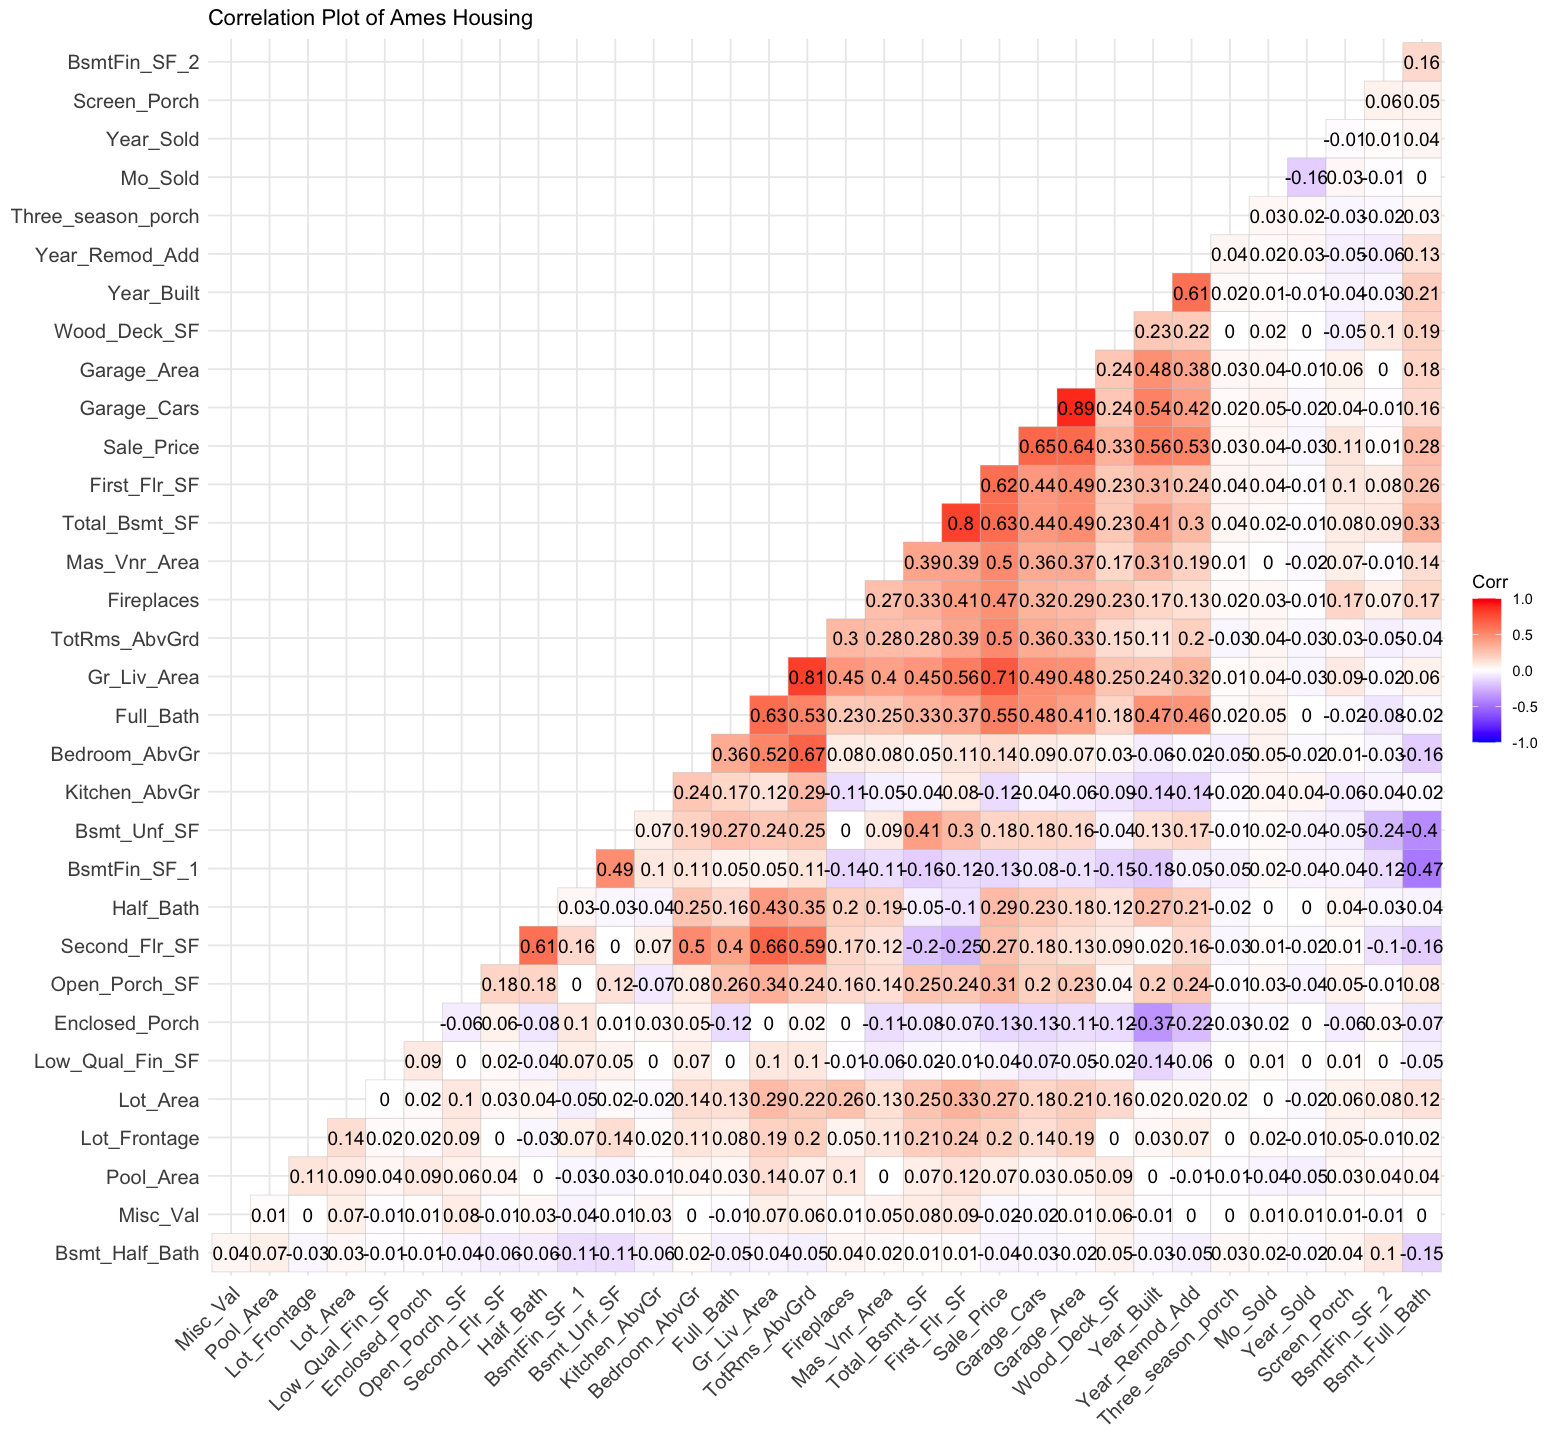

In [8]:
options(repr.plot.width=13, repr.plot.height=12) # adjust x,y size of plot

ggcorrplot(cc2, hc.order = TRUE, type = "lower",
   lab = TRUE)+ggtitle('Correlation Plot of Ames Housing')

# `Using Linear Regression:`

+ Since, you have a chance of increasing multi-collinearity with the increase of features: you will more often than not also have high variability with your coefficients. 

`For example:` `Gr_liv_Area & TotRms_AbvGrnd = 0.81`, `Sale_Price & Gr_liv_Area = 0.71`, `Sale_Price & TotRms_AbvGrnd = 0.5`

# `Notice what happens:`

you end up with a very negaitive number for `TotalRms_AbvGrnd` which means that it is not helping your model

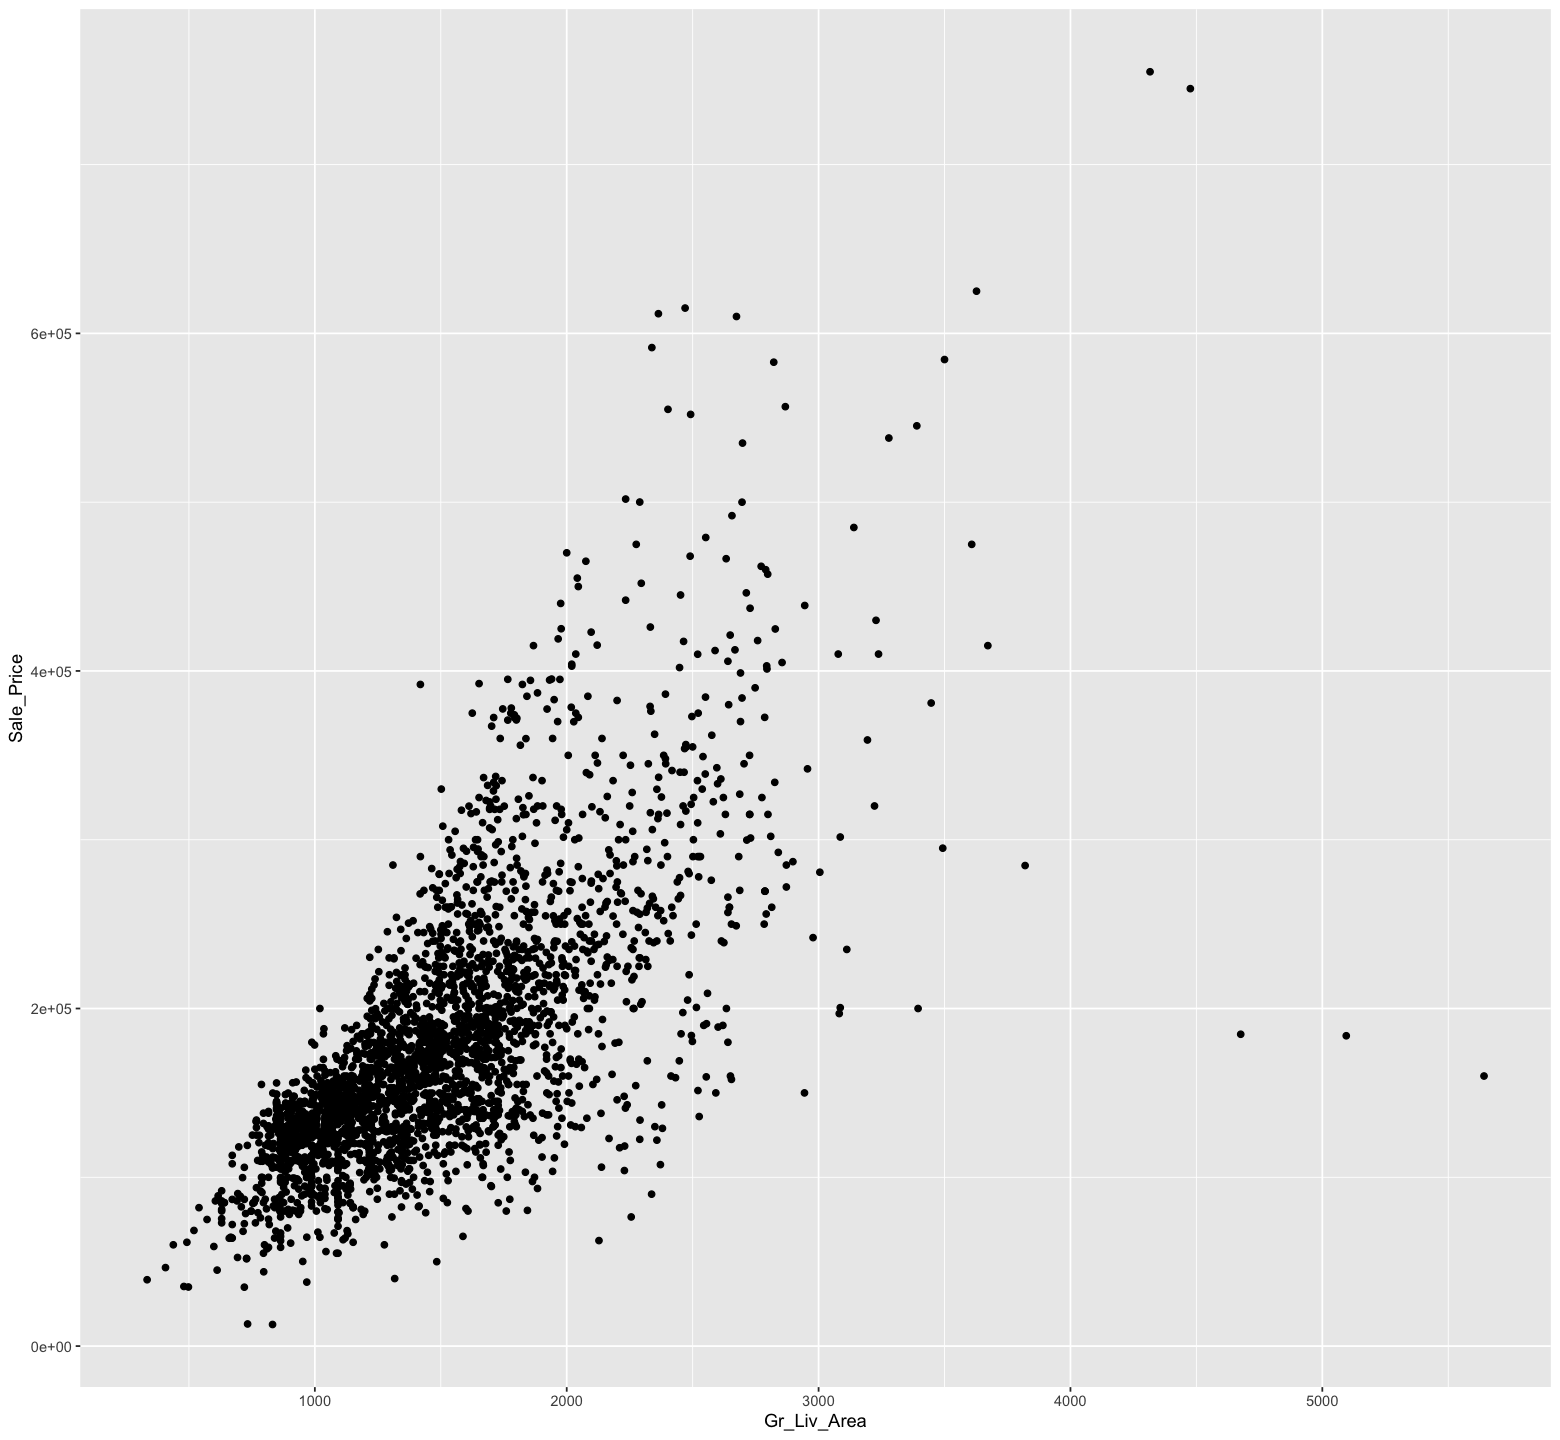

In [9]:
#  Above_Ground_Living_Area by Sales_Price Scatter Plot
ggplot(data=df_updated) + geom_point(mapping= aes(x=Gr_Liv_Area,
y=Sale_Price))

# `Show Linear Model of Sales_Price vs Ground_living Area/Total_Rooms_AboveGround`

In [10]:
lm(Sale_Price ~ Gr_Liv_Area + TotRms_AbvGrd, data = df_updated)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + TotRms_AbvGrd, data = df_updated)

Coefficients:
  (Intercept)    Gr_Liv_Area  TotRms_AbvGrd  
      42767.6          139.4       -11025.9  


# `Notice when they are separated:`

+ First, the effect of `Gr_Liv_Area` has slightly decreased

+ Second, the fact that `TotRms_AbvGrd` has greatly increased by an order of magnitude.

This is a result of collinearity between variables. This is what leads to our overfitting issues and the dreaded `bias-variance tradeoff` you want to adjust.

+ We have to be selective if we are to remove variables because we are also removing information to be learned. 
    + Decreasing dimensions aids in interpretation later but, becareful!
+ Now, we shall add some regularization in order to make our data better reflect what is going on since we are currenlty having issues with meeting `Linear Regression Assumptions`

In [11]:
lm(Sale_Price ~ Gr_Liv_Area, data =df_updated)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area, data = df_updated)

Coefficients:
(Intercept)  Gr_Liv_Area  
    13289.6        111.7  


In [12]:
lm(Sale_Price ~ TotRms_AbvGrd, data = df_updated)


Call:
lm(formula = Sale_Price ~ TotRms_AbvGrd, data = df_updated)

Coefficients:
  (Intercept)  TotRms_AbvGrd  
        18665          25164  


# `Glmnet() Basics:`

`alpha = 0` used for `ridge`

if you place `alpha = 1` you will use `lasso` 

`elastic net` is any value in between (0,1)

+ Behind the scenes, by default your data will be standardized. If you standardized your data beforehand then do: `standardize = FALSE`

+ Also, your ridge/lasso will performed on multiple $\lambda$ values

The $\lambda$ values performed by default `glmnet` will be 100, you can change these if you need to.


# `Ridge Regression:`

+ keeps all variables/features!
    + shrinks towards zero, never exactly zero.

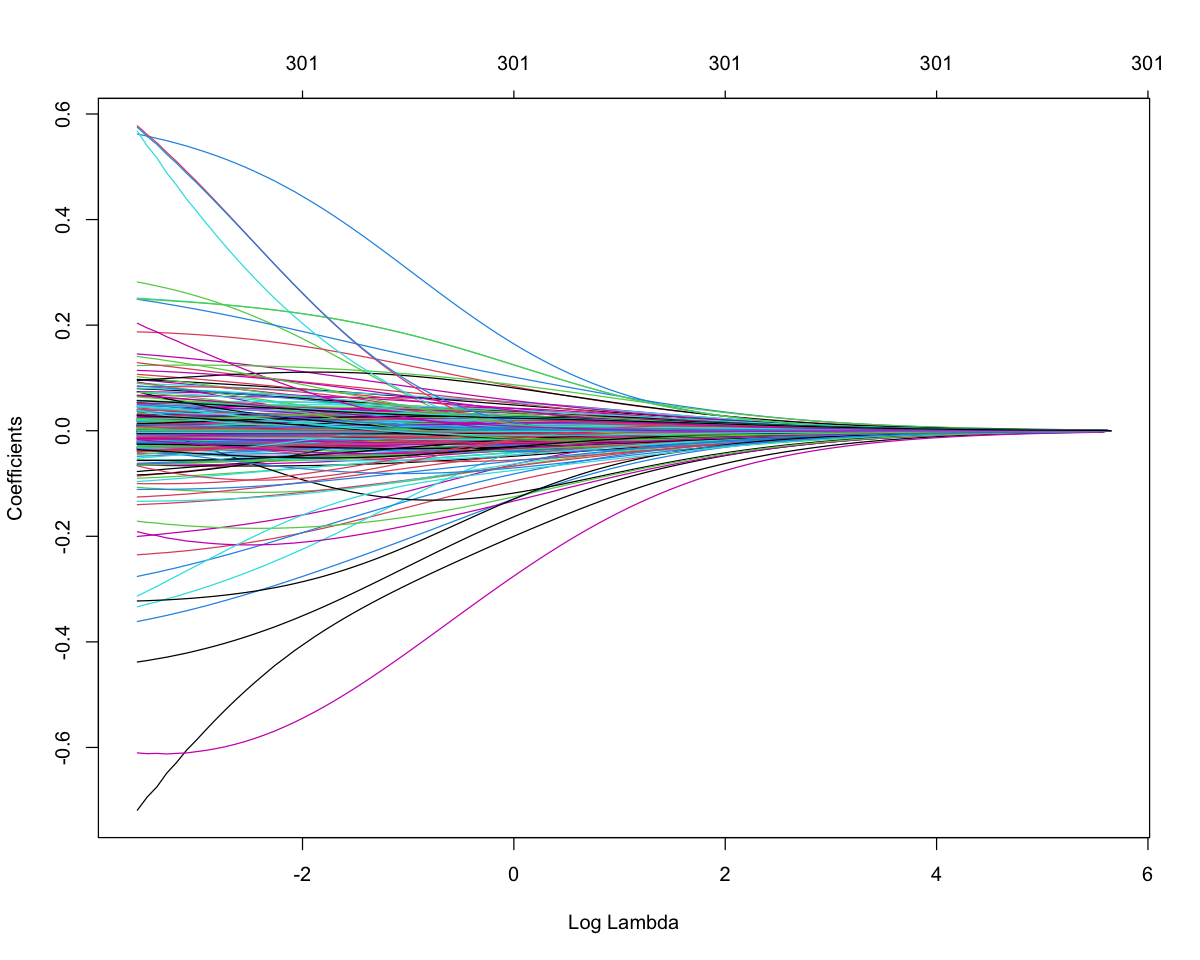

In [13]:
options(repr.plot.width=10, repr.plot.height=8) # adjust x,y size of plot

ames_IA_ridge <- glmnet(
  x = ames_train_x,
  y = ames_train_y,
  alpha = 0
)

plot(ames_IA_ridge, xvar = "lambda")

# `Notice:`

+ As the $\lambda$ increases to max $\lambda$ then the coefficients get really small toward zero

In [14]:
ridge_<- glmnet(x = ames_train_x, y = ames_train_y, alpha = 0)

sprintf('Max Lambda: %.3f',max(ridge_$lambda))
sprintf('Min Lambda: %.3f',min(ridge_$lambda))

# 309 x 100 sparse Matrix
print('Example of Min Coeff')
coef(ridge_)[c("Gr_Liv_Area", "TotRms_AbvGrd"), 1] 
print('Example of Max Coeff.')
coef(ridge_)[c("Gr_Liv_Area", "TotRms_AbvGrd"), 100] 

[1] "Max Lambda: 283.513"

[1] "Min Lambda: 0.028"

[1] "Example of Min Coeff"


Gr_Liv_Area TotRms_AbvGrd 
 5.672501e-40  1.271234e-37

[1] "Example of Max Coeff."


Gr_Liv_Area TotRms_AbvGrd 
 0.0001013357  0.0081356310

# `Now What?`

**Find best values for lambda!**

+ This is done with `Cross Validation!`

+ `Notice:` on the top of the plot there are 301 variables used.
    + The Y-axis: MSE
    + X-axis: $log(\lambda)$
+ `The vertical dashed lines` correspond to your 1 Standard Error  and $(\lambda.min)$

When using `cv.glmnet()` we have a few things to use
+ `type.measure="mse"`
+ `family="gaussian"`

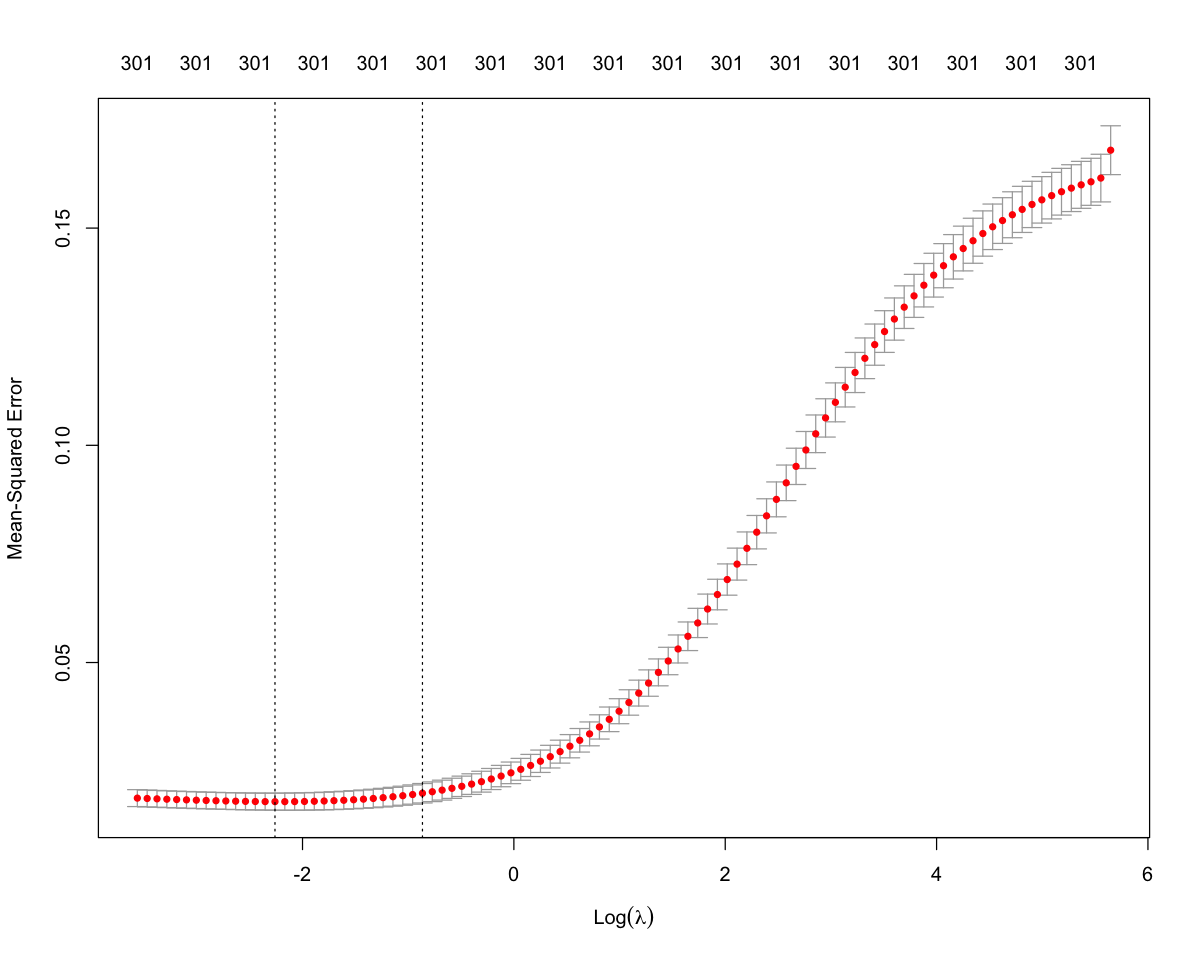

In [15]:
# Apply CV Ridge regression to Ames Iowa dataset
set.seed(2345)
ames_ridge_cv <- cv.glmnet(
  x = ames_train_x,
  y = ames_train_y,
  alpha = 0
)

# plot results
plot(ames_ridge_cv)

# `Training Our Model with CV using Ridge`

In practice we are trying to measure how well our model compares. For instance, the `root mean square error: (RMSE)` or `mean square error: (MSE)` can be used. 

+ This is your predicted error: think of the standard devation of your residuals (how far) you are from the line.

In [16]:
# training set:
ames_IA_ridge <- glmnet(x = ames_train_x,y = ames_train_y,alpha = 0)

# Tuning:
fit.ridge.cv <- cv.glmnet(ames_train_x, ames_train_y, type.measure="mse", alpha=0)

# Predicting Values:
pred_fit_ridge_train <- predict(fit.ridge.cv, ames_train_x, s = "lambda.min")

pred_fit_ridge_test <- predict(ames_IA_ridge, ames_test_x, s =fit.ridge.cv$lambda.min )

In [17]:
print('RIDGE:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_ridge_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_ridge_train-ames_train_y)^2)))

[1] "RIDGE:"


[1] "Test RMSE: 0.1445"

[1] "Train RMSE: 0.1039"

In [18]:
# RIDGE TRAINING:
print('Your Vertical Lines')

min_mse_ridge_cv<-min(fit.ridge.cv$cvm) # minimum MSE

lambda_for_min_mse<-fit.ridge.cv$lambda.min # lambda for this min MSE

#1 std_err for min MSE
minMSE_1stderr_ridge<-fit.ridge.cv$cvm[fit.ridge.cv$lambda == fit.ridge.cv$lambda.1se]

lambda_for_minMSe_1stderr_ridge<-fit.ridge.cv$lambda.1se  # lambda for this MSE

sprintf('Minimum MSE for CV: %.4f',min_mse_ridge_cv)
sprintf('Lambda for Corresponding Min. MSE : %.4f',lambda_for_min_mse)
sprintf('Min MSE for 1st Error: %.4f',minMSE_1stderr_ridge)
sprintf('Corresponding Lambda for 1 Std Err : %.4f',lambda_for_minMSe_1stderr_ridge)

sprintf('Log(Lambda Min. MSE): %.4f',log(fit.ridge.cv$lambda.min))
sprintf('Log(Lambda 1 Std Error MSE): %.4f',log(fit.ridge.cv$lambda.1se))

[1] "Your Vertical Lines"


[1] "Minimum MSE for CV: 0.0179"

[1] "Lambda for Corresponding Min. MSE : 0.1043"

[1] "Min MSE for 1st Error: 0.0202"

[1] "Corresponding Lambda for 1 Std Err : 0.4621"

[1] "Log(Lambda Min. MSE): -2.2606"

[1] "Log(Lambda 1 Std Error MSE): -0.7721"

`Don't get hung up on the Test data looking worse than the Training RMSE.`

+ You need to understand that we are trying to NOT overfit
+ We will try other methods to see what is our best
    + As well as average our best models to get an idea
+ Remember the Bias-Variance Tradeoff for interpreting ok...

**`(ABOVE ALL: SMILE and have fun!!!!)`**

# `How about getting some visual stimulus:`

Bascially, we are able to constrain our parameters within these red lines while maximzing the predictive accuracy in our case `RMSE`

This will become clear when we use `Lasso` for feature selection, yay.

`Above all, `Ridge` did make an effort to push our uninteresting (useless) features toward zero and handles the correleated variables.` Unfortunately, we still have to get rid of noise, while it is minimized: we can do better. 
+ But, we will need to remove variables to do so and lose information in the process.

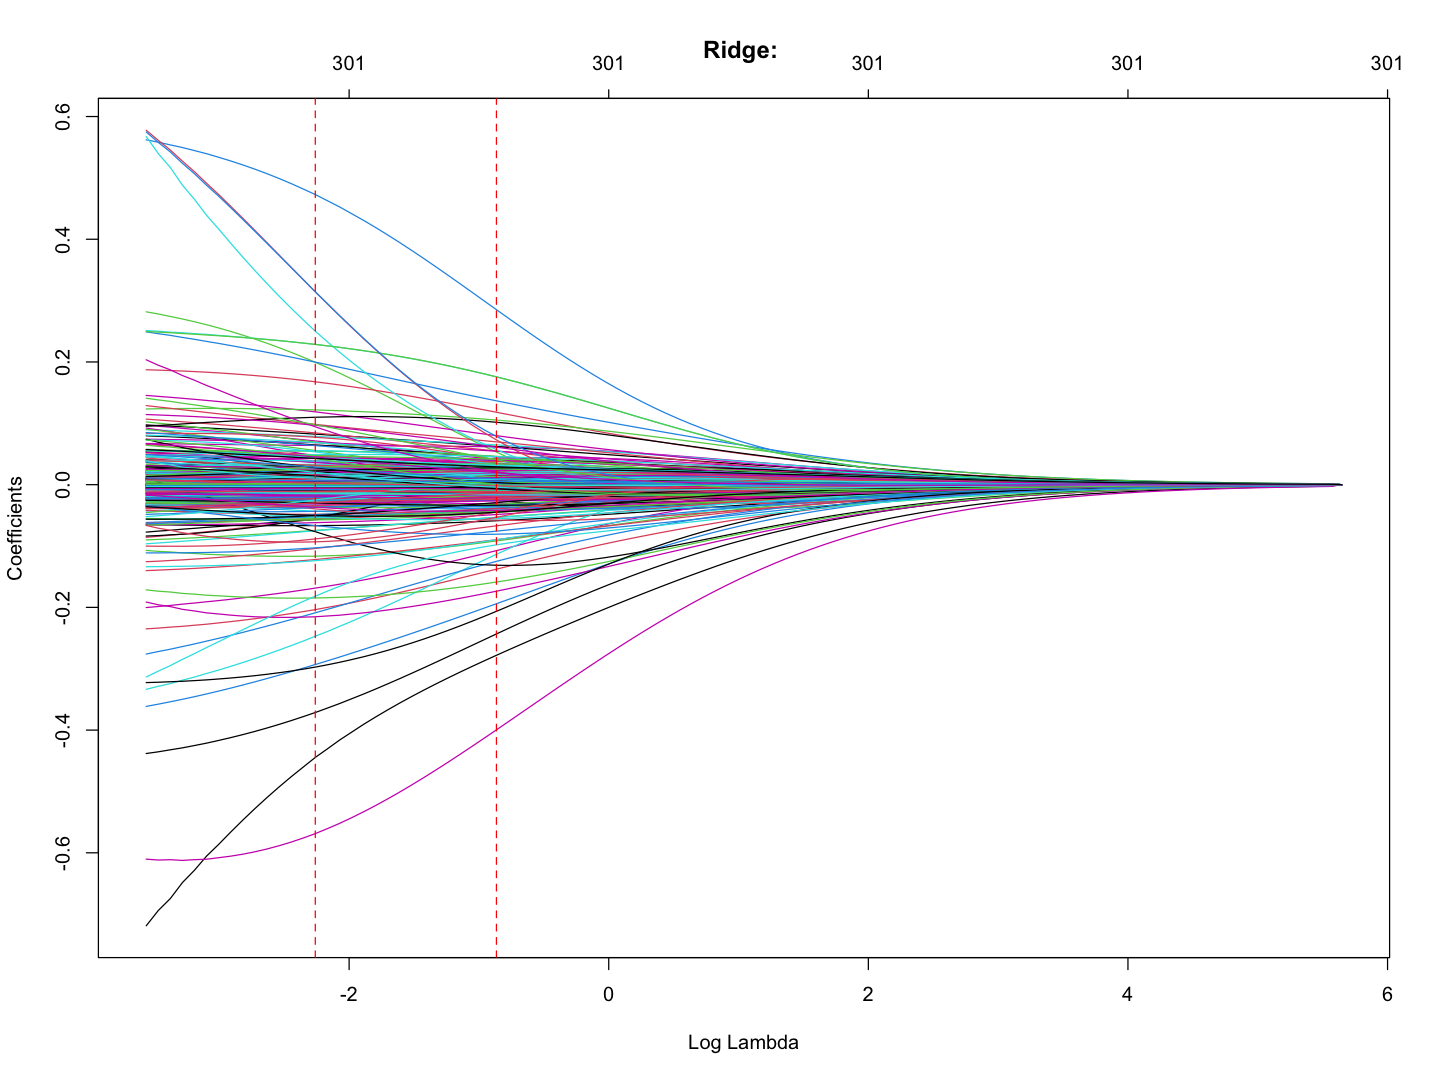

In [19]:
options(repr.plot.width=12, repr.plot.height=9) # adjust x,y size of plot
set.seed(2345)
ames_ridge_min <- glmnet(
  x = ames_train_x,
  y = ames_train_y,
  alpha = 0
)

plot(ames_ridge_min, xvar = "lambda",main = 'Ridge: ')
abline(v = log(ames_ridge_cv$lambda.1se), col = "red", lty = "dashed")
abline(v = log(ames_ridge_cv$lambda.min), col = "red", lty = "dashed")

# `Let's view our 25 MOST intersting features for Ridge:`

+ `Why use Ridge vs Lasso?`
Consider if we believed that we needed to retain all variables but, wanted to reduce noisy data. This would be a good choice to start.
    + But, you are keeping all variables so if you have a crazy amount of features this may cause some issues: computation, interpretation etc.

Warning message:
“'tidy.dgCMatrix' is deprecated.
See help("Deprecated")”
Warning message:
“'tidy.dgTMatrix' is deprecated.
See help("Deprecated")”


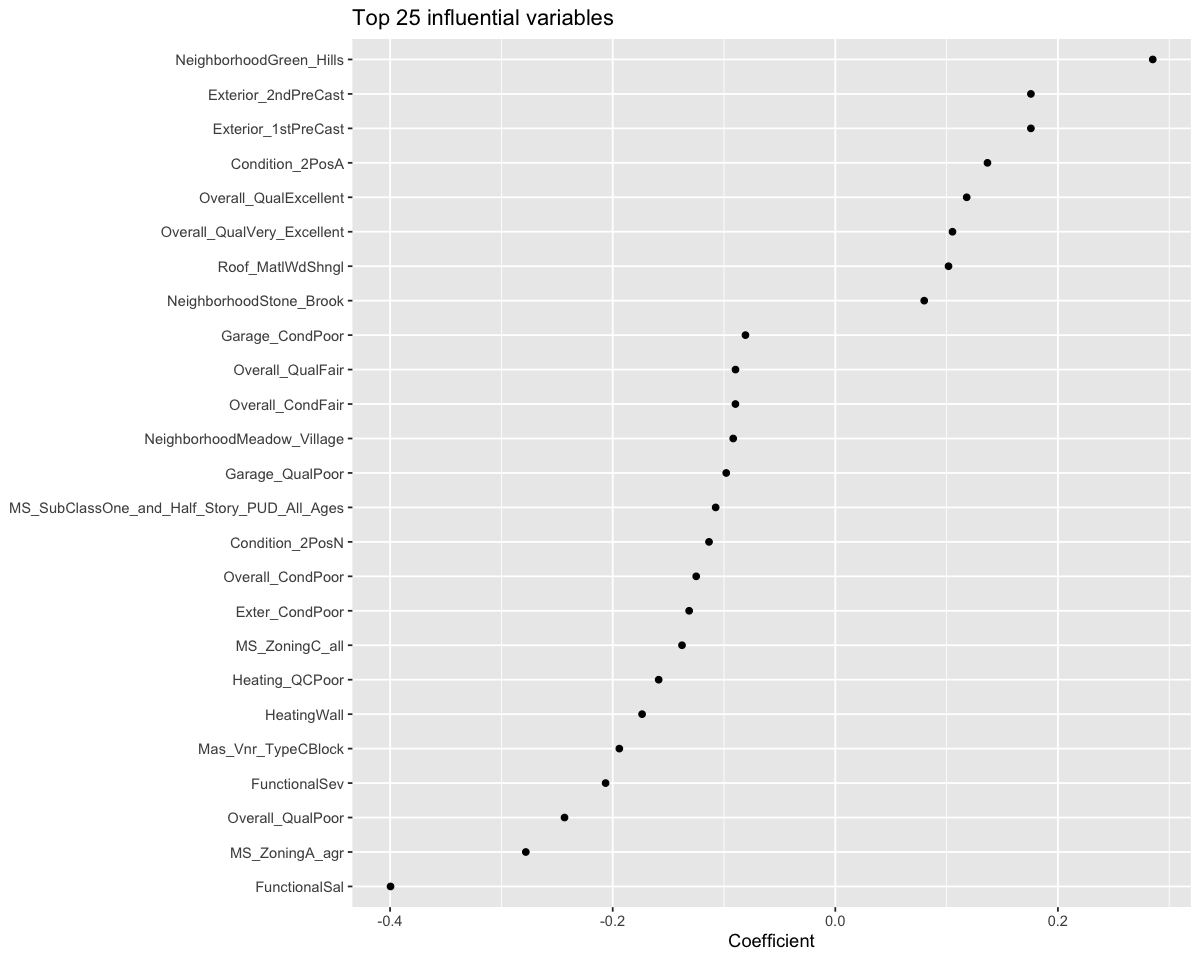

In [20]:
options(repr.plot.width=10, repr.plot.height=8) # adjust x,y size of plot

coef(ames_ridge_cv, s = "lambda.1se") %>%
  tidy() %>%
  filter(row != "(Intercept)") %>%
  top_n(25, wt = abs(value)) %>%
  ggplot(aes(value, reorder(row, value))) +
  geom_point() +
  ggtitle("Top 25 influential variables") +
  xlab("Coefficient") +
  ylab(NULL)

# `Lasso Regression:`

+ Good old feature extraction, yippie.

**`Notice:`** at the top of the plot we have reduce the number of features from 302, to 284. Not a lot but something ~6% downgrade.

`BUT, that isn't the whole story! You will only need the number of features in your sweet spot.. So it gets better`

**1. )** look at the $\lambda=-10$, you will see that most features are correlated and causing high OLS.
**2. )** as we reach $\lambda=-6$ the features are going toward zero and really suggest this by $\lambda=-4$ and our noisy data is going away.
    * There are probably a good amount of features that were correlated with each other
**3. )** At the point of $-6<log(\lambda)<-4$ we will soon see that this is where our sweet spot is. It will lie between our `1 SE and Min. Lambda`

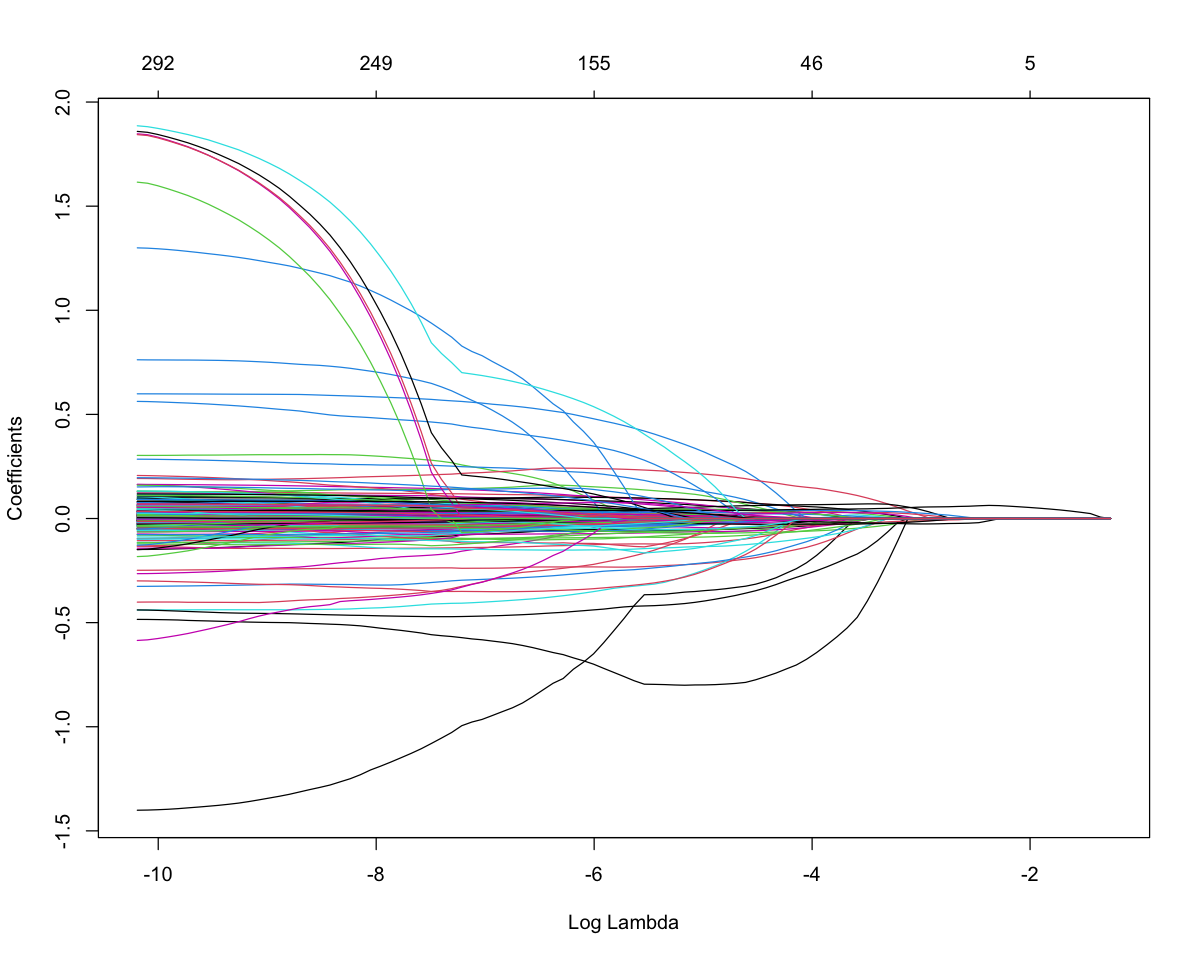

In [21]:
# Apply Lasso Regression:
set.seed(2345)
ames_lasso <- glmnet(
  x = ames_train_x,
  y = ames_train_y,
  alpha = 1
)

plot(ames_lasso, xvar = "lambda")

# `Look at the Top of the plot:`

`We are essentially narrowing our range of features between 64 & ~140`

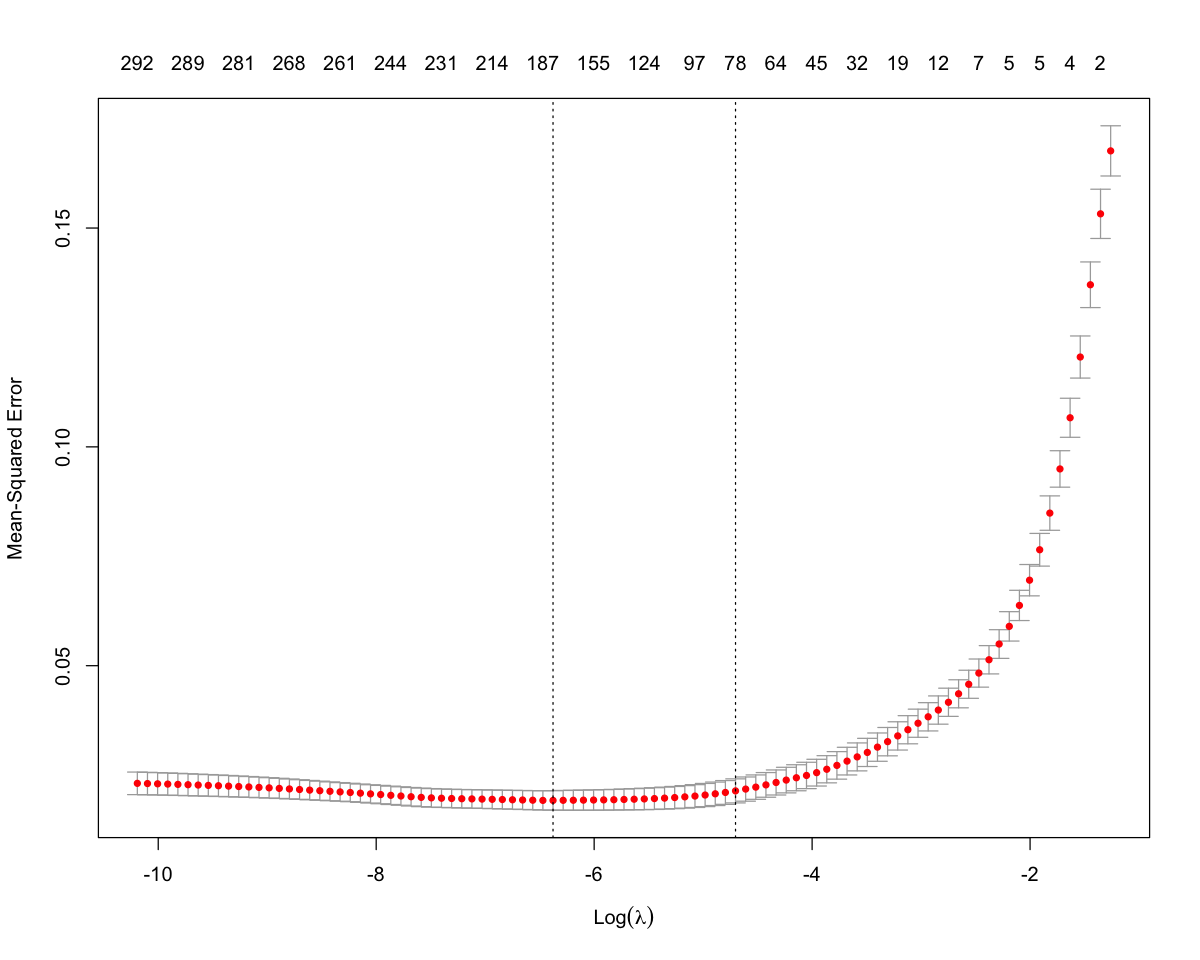

In [22]:
# Cross Val. Lasso:
set.seed(2345)
ames_lasso_cv <- cv.glmnet(
  x = ames_train_x,
  y = ames_train_y,
  alpha = 1
)
# plot results
plot(ames_lasso_cv)

In [23]:
# LASSO TRAINING:
print('Your Vertical Lines w/ corresponding information')
min_mse_lasso_cv<-min(ames_lasso_cv$cvm)       # minimum MSE

lambda_for_min_mse_lasso<-ames_lasso_cv$lambda.min  # lambda for this min MSE

# 1 st.error of min MSE
minMSE_1stderr_lasso<-ames_lasso_cv$cvm[ames_lasso_cv$lambda == ames_lasso_cv$lambda.1se]

lambda_for_minMSe_1stderr_lasso<-ames_lasso_cv$lambda.1se  # lambda for this MSE


sprintf('Min. MSE for CV: %.4f',min_mse_lasso_cv)
sprintf('Lambda for Corresponding Min. MSE : %.4f',lambda_for_min_mse)
sprintf('Min MSE for 1st Error: %.4f',minMSE_1stderr_lasso)
sprintf('Corresponding Lambda for 1 Std Err : %.4f',lambda_for_minMSe_1stderr_lasso)

sprintf('Log(Lambda Min. MSE): %.3f',log(lambda_for_min_mse_lasso))
sprintf('Log(Lambda 1 Std Error MSE): %.3f',log(lambda_for_minMSe_1stderr_lasso))

[1] "Your Vertical Lines w/ corresponding information"


[1] "Min. MSE for CV: 0.0192"

[1] "Lambda for Corresponding Min. MSE : 0.1043"

[1] "Min MSE for 1st Error: 0.0214"

[1] "Corresponding Lambda for 1 Std Err : 0.0091"

[1] "Log(Lambda Min. MSE): -6.377"

[1] "Log(Lambda 1 Std Error MSE): -4.703"

In [24]:
# training set:
set.seed(2345)
ames_IA_lasso <- glmnet(x = ames_train_x,y = ames_train_y,alpha = 1)

# Tuning:
fit.lasso.cv <- cv.glmnet(ames_train_x, ames_train_y, type.measure="mse", alpha=1)

# Predicting Values:
pred_fit_lasso_train <- predict(fit.lasso.cv, ames_train_x, s = "lambda.min")

pred_fit_lasso_test <- predict(ames_IA_lasso, ames_test_x, s =fit.lasso.cv$lambda.min )

In [25]:
print('LASSO:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_lasso_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_lasso_train-ames_train_y)^2)))

[1] "LASSO:"


[1] "Test RMSE: 0.1474"

[1] "Train RMSE: 0.1007"

In [26]:
print('RIDGE:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_ridge_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_ridge_train-ames_train_y)^2)))

[1] "RIDGE:"


[1] "Test RMSE: 0.1445"

[1] "Train RMSE: 0.1039"

# `LASSO Influential Features:`
+ While we were able to forego reducing our features, there is also a sacrifice with your prediction accuracy.
    + Again, just like `Ridge` you're collinear features will get pushed toward each other instead of showing trends such as going really positive/negative.
    + Fortunately, we are able to push the variables 'features' `to exactly zero` unlike ridge. 
        + This helps us for interpration. 
        
As $\lambda$ increases more coefficients will go to zero and less predictors are selected.

Warning message:
“'tidy.dgCMatrix' is deprecated.
See help("Deprecated")”
Warning message:
“'tidy.dgTMatrix' is deprecated.
See help("Deprecated")”


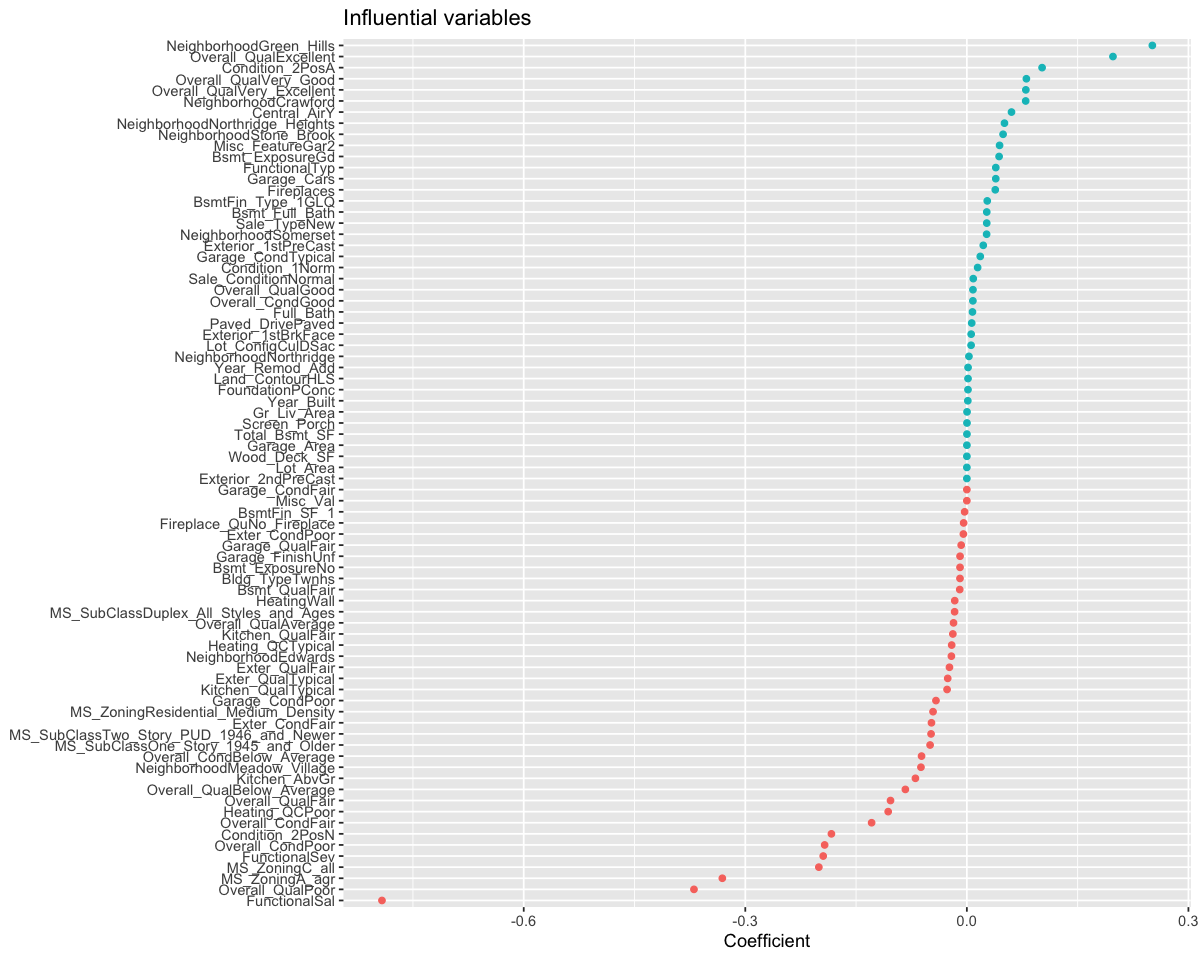

In [27]:
coef(ames_lasso_cv, s = "lambda.1se") %>%
  tidy() %>%
  filter(row != "(Intercept)") %>%
  ggplot(aes(value, reorder(row, value), color = value > 0)) +
  geom_point(show.legend = FALSE) +
  ggtitle("Influential variables") +
  xlab("Coefficient") +
  ylab(NULL)

# `Before we move on let's notice something:`

+ The slight differenes between the MSE for Lasso and Ridge can have drastic effects when you are doing a competition for example Kaggle. Since, we are trying to minimize our error.


In [28]:
# minimum Ridge MSE
round(min(ames_ridge_cv$cvm),4)

# minimum Lasso MSE
round(min(ames_lasso_cv$cvm),4)


[1] 0.018

[1] 0.0192

In [29]:
# options(repr.plot.width=10, repr.plot.height=8) # adjust x,y size of plot

# Plot solution paths:
# par(mfrow=c(2,2))
# For plotting options, type '?plot.glmnet' in R console
# plot(ames_lasso_cv, xvar="lambda")
# plot(ames_lasso, main="LASSO")

# plot(ames_ridge_cv, xvar="lambda")
# plot(ames_ridge_min, main="Ridge")

# `Elastic Net:`

+ `Downside with Lasso: NOT strickly convex`
+ What does this mean?
    + If we had let's say 2 features that were identical then we wouldn't be able to distinguish them when trying to minimize. In such an instance, we would consider Elastic Net.
    + Elastic Net, would give us a unique solution in that circumstance
    
When we are using `Elastic Net` we get the combination of Ridge and Lasso:

<font size=4>$L_{ElasticNet}(\hat\beta)=\frac{\sum\limits_{i-1}^{n}(y_i-x^T\hat\beta)^2}{2}+{\lambda(\frac{1-\alpha}{2})}\sum\limits_{j-1}^{m}\hat\beta_{j}^{2}+\alpha\sum\limits_{j-1}^{m}||\lambda||$</font>

+ Elstic Net, allows us to establish regularization with a combination of Lasso and Ridge but there are downsides. While we are able to reduce noise and collinearity; we are still restricted to linear assumptions!
    + Finding a specific alpha, in our case can be time consuming considering that we are iterating to find an optimum value retreiving the lowest rmse or mse.
+ If you are in a situation where you think or observe non-linear behavior: switch models and look at non-linear regression for example

#dfgdfg

In [30]:
lists.of.your.fits<-list()
for(i in 0:10){
    fit.name<-paste0('alpha',i/10)
    lists.of.your.fits[[fit.name]]<-(cv.glmnet(ames_train_x,ames_train_y,
    type.measure='mse',alpha=i/10))
}
results<-data.frame()
for(i in 0:10){
    fit.name<-paste0('alpha',i/10)
    predicted<-(predict(lists.of.your.fits[[fit.name]],
    s=lists.of.your.fits[[fit.name]]$lambda.min,newx=ames_test_x))
    
    rmse<-sqrt(mean(predicted-ames_test_y)^2)
    temp<-data.frame(alpha=i/10,fit.name=fit.name,rmse=rmse)
    results<-rbind(results,temp)
}


In [31]:
results

alpha fit.name rmse       
1  0.0   alpha0   0.004600150
2  0.1   alpha0.1 0.004791627
3  0.2   alpha0.2 0.005103627
4  0.3   alpha0.3 0.005218868
5  0.4   alpha0.4 0.005329625
6  0.5   alpha0.5 0.005457230
7  0.6   alpha0.6 0.005504254
8  0.7   alpha0.7 0.005287067
9  0.8   alpha0.8 0.005526276
10 0.9   alpha0.9 0.005682672
11 1.0   alpha1   0.005699134

In [38]:
# training set:
set.seed(2345)
ames_IA_enet <- glmnet(x = ames_train_x,y = ames_train_y,alpha = .5)

# Tuning:
fit.enet.cv <- cv.glmnet(ames_train_x, ames_train_y, type.measure="mse", alpha=.5)

# Predicting Values:
pred_fit_enet_train <- predict(fit.enet.cv, ames_train_x, s = "lambda.min")

pred_fit_enet_test <- predict(ames_IA_enet, ames_test_x, s =fit.enet.cv$lambda.min )

In [39]:
print('Elastic Net alpha=0.5:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_enet_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_enet_train-ames_train_y)^2)))

[1] "Elastic Net alpha=0.5:"


[1] "Test RMSE: 0.1467"

[1] "Train RMSE: 0.1008"

In [34]:
print('LASSO:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_lasso_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_lasso_train-ames_train_y)^2)))
print('---------------------')
print('RIDGE:')
sprintf('Test RMSE: %.4f',sqrt(mean((pred_fit_ridge_test-ames_test_y)^2)))
sprintf('Train RMSE: %.4f',sqrt(mean((pred_fit_ridge_train-ames_train_y)^2)))

[1] "LASSO:"


[1] "Test RMSE: 0.1474"

[1] "Train RMSE: 0.1007"

[1] "---------------------"
[1] "RIDGE:"


[1] "Test RMSE: 0.1445"

[1] "Train RMSE: 0.1039"

# `Take away:`

+ `Lasso` was our best model for these data
    + Elastic net was no better than ridge
    
`Finishing Thoughts:`
+ Depending if you use the raw file or formatted file you will need to do quite a bit of work getting started.
    + I am not sure if the files are updated or changed.
+ If you have the kaggle dataset vs using the library from R-studio: I do not know what the differences are for the data and not sure how your results will be in the end.
+ Also, depending on the preprocessing before model selection you will get different results.
+ Also, depending on your dummy variable creation and what you use will affect results.
    + such as disregarding sporadic data points and outliers.
+ There's always room to improve.

Finally, reviewing other people who have done this I see differing results and 3 files where Ridge beat Lasso and I am wondering what is different from my approach!

# <font color=red>Like</font>,Share &

# <font color=red>SUB</font>scribe

# `Citations & Help:`

# ◔̯◔

https://uc-r.github.io/regularized_regression (example with code and explanation)

https://www.youtube.com/watch?v=ctmNq7FgbvI

https://www.datacareer.de/blog/ridge-and-lasso-in-r/ (code in R)

https://rpubs.com/beane/n6_1 (example with code)

https://www.pluralsight.com/guides/linear-lasso-and-ridge-regression-with-r

https://rpubs.com/uky994/579407

https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html

https://www.geo.fu-berlin.de/en/v/soga/Geodata-analysis/multiple-regression/Regularization-Methods/Regularization-Methods-in-R/index.html

https://www.kaggle.com/kiyoung1027/linear-model-mlr-lasso-ridge-and-elastic-net

`One Standard Deviation Rule:`

https://stats.stackexchange.com/questions/348587/lasso-selection-of-penalty-term-one-standard-error-rule

https://www.cs.cmu.edu/~psarkar/sds383c_16/lecture9_scribe.pdf

`Ames Housing Example`

http://course1.winona.edu/thooks/Media/Handout%2020%20-%20Introduction%20to%20ggplot2.pdf

http://rstudio-pubs-static.s3.amazonaws.com/256459_5a62c0ca6d5849af92607011bb6c3e1d.html

https://remiller1450.github.io/s230s19/Intro_to_ggplot.html

https://www.kaggle.com/mchatham/ames-housing-regression (python)

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset (python)

http://rstudio-pubs-static.s3.amazonaws.com/373113_ba8a4073956f4587b8f5036435e877d6.html

https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda

https://rpubs.com/RobbyS/622233